In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os 



# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [2]:
query = query_schema + """
SELECT *
FROM D_ICD_DIAGNOSES
WHERE icd9_code IN {ARDS_list}
"""

# ARDS_list = ("469", "51882", "5185", "460", "461", "462", "463", "464", "465", "466", "465", "4611", "4619", "4640", "4643", "4644", "4659", "4660","46611",)
ARDS_list = ('51881', '51882', '51884', '51851', '51852', '51853', '769')
# df = pd.read_sql_query(query, con)
df = pd.read_sql_query(query.format(ARDS_list=ARDS_list), con)
print("Number of rows :", len(df))
# ARDS_hadm = np.unique(df["hadm_id"])
with pd.option_context('display.max_colwidth', 400):
    display(df.head(50))

Number of rows : 7


,row_id,icd9_code,short_title,long_title
0,5274,51851,Ac resp flr fol trma/srg,Acute respiratory failure following trauma and surgery
1,5275,51852,Ot pul insuf fol trm/srg,"Other pulmonary insufficiency, not elsewhere classified, following trauma and surgery"
2,5276,51853,Ac/chr rsp flr fol tr/sg,Acute and chronic respiratory failure following trauma and surgery
3,5279,51881,Acute respiratry failure,Acute respiratory failure
4,5280,51882,Other pulmonary insuff,"Other pulmonary insufficiency, not elsewhere classified"
5,5282,51884,Acute & chronc resp fail,Acute and chronic respiratory failure
6,8702,769,Respiratory distress syn,Respiratory distress syndrome in newborn


In [3]:
query = query_schema + """
SELECT D_ICD_DIAGNOSES.icd9_code, D_ICD_DIAGNOSES.long_title, COUNT(*)
FROM DIAGNOSES_ICD
JOIN D_ICD_DIAGNOSES ON D_ICD_DIAGNOSES.icd9_code = DIAGNOSES_ICD.icd9_code
WHERE D_ICD_DIAGNOSES.icd9_code in {ARDS_list}
GROUP BY D_ICD_DIAGNOSES.icd9_code
"""

query = query_schema + """
CREATE TEMP TABLE ARDS_COUNTS AS
SELECT D_ICD_DIAGNOSES.icd9_code, count as n_patients, long_title
FROM (SELECT icd9_code, COUNT(*)
      FROM DIAGNOSES_ICD
      WHERE icd9_code in {ARDS_list}
      GROUP BY icd9_code) AS subquery
JOIN D_ICD_DIAGNOSES ON D_ICD_DIAGNOSES.icd9_code = subquery.icd9_code
"""


# query = query_schema + """
# SELECT *
# FROM DIAGNOSES_ICD
# JOIN D_ICD_DIAGNOSES ON D_ICD_DIAGNOSES.icd9_code = DIAGNOSES_ICD.icd9_code
# WHERE D_ICD_DIAGNOSES.icd9_code in {ARDS_list}
# """

# ARDS_list = ("469", "51882", "5185", "460", "461", "462", "463", "464", "465", "466", "465", "4611", "4619", "4640", "4643", "4644", "4659", "4660","46611",)
# ARDS_list = ('51882', '0')
# print(ARDS_list)
# print(query)
# con.rollback()
cur = con.cursor()
cur.execute("DROP TABLE IF EXISTS ARDS_COUNTS")
cur.execute(query.format(ARDS_list=ARDS_list))
df = pd.read_sql_query("SELECT * FROM ARDS_COUNTS", con)
print("Number of rows :", len(df))
# ARDS_hadm = np.unique(df["hadm_id"])
df = pd.concat((df, pd.DataFrame({'icd9_code':['total'], 'n_patients':[46520], 'long_title':['All']})))
# df = 
with pd.option_context('display.max_colwidth', 400):
    display(df.head(50))

Number of rows : 4


,icd9_code,n_patients,long_title
0,51881,2908,Acute respiratory failure
1,51882,408,"Other pulmonary insufficiency, not elsewhere classified"
2,51884,342,Acute and chronic respiratory failure
3,769,1313,Respiratory distress syndrome in newborn
0,total,46520,All


In [4]:
query = query_schema + """
SELECT *
FROM DIAGNOSES_ICD
JOIN D_ICD_DIAGNOSES ON D_ICD_DIAGNOSES.icd9_code = DIAGNOSES_ICD.icd9_code
WHERE D_ICD_DIAGNOSES.icd9_code NOT IN {ARDS_list}
"""

# ARDS_list = ("469", "51882", "5185", "460", "461", "462", "463", "464", "465", "466", "465", "4610", "4611", "4619", "4640", "4643", "4644", "4659", "4660","46611",)
ARDS_list = ('51882', '0')
df = pd.read_sql_query(query.format(ARDS_list=ARDS_list), con)
print("Number of rows :", len(df))
ARDS_hadm = np.unique(df["hadm_id"])
df.head()

Number of rows : 214992


,row_id,subject_id,hadm_id,seq_num,icd9_code,row_id,icd9_code,short_title,long_title
0,1,2,163353,1,V3001,13695,V3001,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b..."
1,2,2,163353,2,V053,12202,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...
2,3,2,163353,3,V290,13688,V290,NB obsrv suspct infect,Observation for suspected infectious condition
3,4,3,145834,1,0389,660,0389,Septicemia NOS,Unspecified septicemia
4,5,3,145834,2,78559,12992,78559,Shock w/o trauma NEC,Other shock without mention of trauma


In [5]:
normal_hadm = np.random.choice(ARDS_hadm, size=len(ARDS_hadm), replace=False)

Number of rows : 28383


(0.0, 100.0)

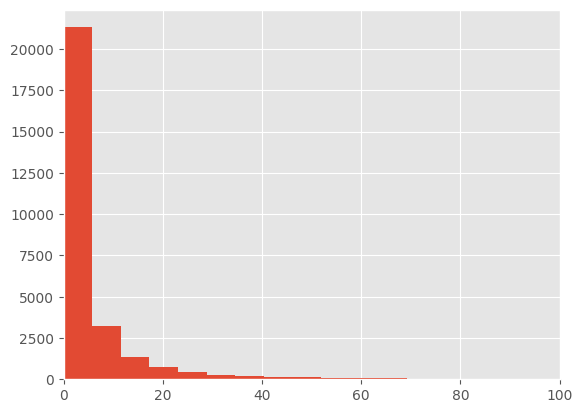

In [6]:
query = query_schema + """
SELECT los, hadm_id
FROM ICUSTAYS
WHERE hadm_id IN {ARDS_hadm}
"""

# ARDS_list = ("469", "51882", "5185", "460", "461", "462", "463", "464", "465", "466", "465", "4610", "4611", "4619", "4640", "4643", "4644", "4659", "4660","46611",)
# ARDS_list = ('51882', '0')
# df = pd.read_sql_query(query, con)
df = pd.read_sql_query(query.format(ARDS_hadm=tuple(ARDS_hadm)), con)
print("Number of rows :", len(df))
# normal_hadm = np.unique(df["hadm_id"])
df.head()
plt.hist(df['los'], 30)
plt.xlim([0, 100])

Number of rows : 28383


(0.0, 100.0)

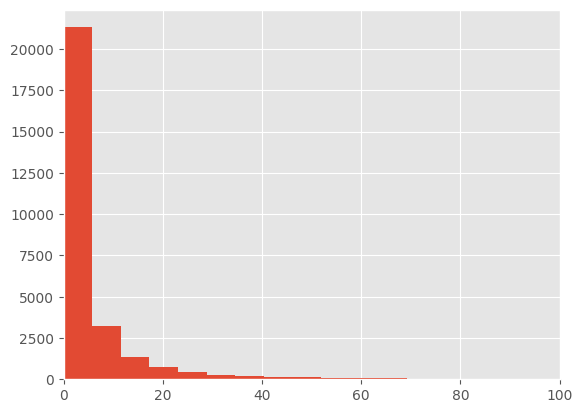

In [7]:
query = query_schema + """
SELECT los, hadm_id
FROM ICUSTAYS
WHERE hadm_id IN {hadm}
"""

# ARDS_list = ("469", "51882", "5185", "460", "461", "462", "463", "464", "465", "466", "465", "4610", "4611", "4619", "4640", "4643", "4644", "4659", "4660","46611",)
# ARDS_list = ('51882', '0')
# df = pd.read_sql_query(query, con)
df = pd.read_sql_query(query.format(hadm=tuple(normal_hadm)), con)
print("Number of rows :", len(df))
df.head()
plt.hist(df['los'], 30)
plt.xlim([0, 100])